In [1]:
import base64
import datetime
import json
import os
import random
import time

import scipy
from scipy import ndimage
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import statsmodels as sm
from pylab import rcParams
from pylab import *
from matplotlib.dates import date2num , DateFormatter
from PIL import Image
from sklearn import preprocessing


np.random.seed(1337)

%matplotlib inline
sns.set(font_scale=1.0)
rcParams['figure.figsize'] = 8, 6
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Load the Data

In [2]:
d = pd.read_json('tmp/raw_data.json')
d.index.name = 'id'
d = d[['building_id', 'latitude', 'longitude', 'interest_level']]
print len(d)

124011


In [3]:
d.dtypes

building_id        object
latitude          float64
longitude         float64
interest_level     object
dtype: object

In [4]:
d.building_id.head()

id
0       79780be1514f645d7e6be99a3de696c5
1                                      0
10      53a5b119ba8f7b61d4e010512e0dfc85
100     3dbbb69fd52e0d25131aa1cd459c87eb
1000    783d21d013a7e655bddc4ed0d461cc5e
Name: building_id, dtype: object

In [5]:
d.building_id.value_counts().head(5)

0                                   20664
96274288c84ddd7d5c5d8e425ee75027      705
11e1dec9d14b1a9e528386a2504b3afc      546
bb8658a3e432fb62a440615333376345      522
80a120d6bc3aba97f40fee8c2204524b      510
Name: building_id, dtype: int64

In [6]:
print d.building_id.value_counts()['0']
print len(d[d.building_id.isnull()])

20664
0


# Fill in Missing Values

In [7]:
d['building_id_was_missing'] = 0.0
d.loc[d.building_id == '0', 'building_id_was_missing'] = 1.0

In [8]:
def get_building_id_by_latlon(lat, lon):
    try:
        return d[((d.building_id != '0') & (d.latitude == lat) & (d.longitude == lon))].building_id.value_counts().index[0]
    except:
        return np.nan

In [9]:
d.loc[d.building_id == '0', 'building_id'] = d[d.building_id == '0'].apply(lambda r: get_building_id_by_latlon(r['latitude'], r['longitude']), axis=1)

In [10]:
print len(d[d.building_id.isnull()])

4122


In [11]:
d['building_id_is_missing'] = 0.0
d.loc[d.building_id.isnull(), 'building_id_is_missing'] = 1.0

# Building Interest Level

In [12]:
ilm = {'low': 0.0, 'medium': 1.0, 'high': 2.0} 
d.interest_level = d.interest_level.map(ilm)

In [13]:
building_ids = d.building_id.dropna().unique().tolist()

In [14]:
d['building_avg_interest'] = np.nan
for bid in building_ids:
    d.loc[d.building_id == bid,
          'building_avg_interest'] = d[d.building_id == bid].interest_level.mean()

In [15]:
d['building_sample_avg_interest'] = np.nan
for bid in building_ids:
    d.loc[d.building_id == bid,
          'building_sample_avg_interest'] = d[d.building_id == bid].interest_level.sample(frac=0.5).mean()

# Number of Apartments in the Same Building

In [16]:
vc = d.building_id.value_counts()
d['num_apts_in_building'] = np.nan
for bid in building_ids:
    d.loc[d.building_id == bid, 'num_apts_in_building'] = vc[bid]
d.loc[d.building_id == '0', 'num_apts_in_building'] = np.nan

# Number of Apartments in the Same Building Bucket

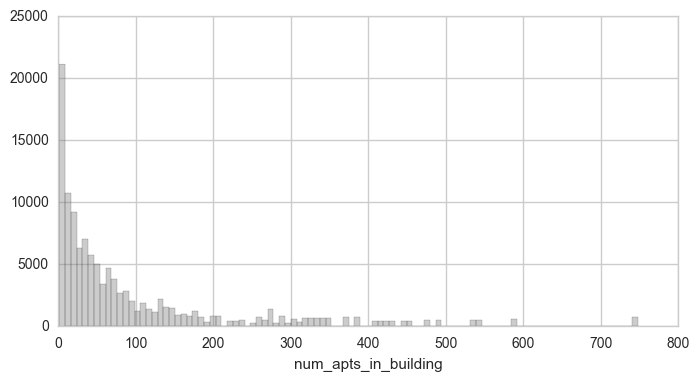

In [17]:
plt.figure(figsize=(8, 4))
ax = sns.distplot(a=d.num_apts_in_building.dropna(), color='grey', kde=False, bins=100)

In [18]:
d.num_apts_in_building.dropna().quantile([(0.1 * i) for i in range(1, 10)])

0.1      4.0
0.2     10.0
0.3     19.0
0.4     31.0
0.5     45.0
0.6     66.0
0.7     95.0
0.8    153.0
0.9    295.0
Name: num_apts_in_building, dtype: float64

In [19]:
d['num_apts_in_building_q10'] = pd.qcut(d.num_apts_in_building, 10, [0.1 * i for i in range(0, 10)])

# Encode buildings

In [20]:
lbl = preprocessing.LabelEncoder()
lbl.fit(list(d.building_id.values))
d.loc[:, 'building_code'] = lbl.transform(list(d.building_id.values))
d.loc[d.building_id.isnull(), 'building_code'] = np.nan

/Library/Python/2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


# Save the Data

In [21]:
del d['latitude']
del d['longitude']
del d['interest_level']

In [25]:
d.to_csv('tmp/features_building_id.csv')